In [22]:
import nengo
import nengo.spa as spa
from nengo.spa import Vocabulary
import numpy as np

In [23]:
rng = np.random.RandomState(12)
dim = 64*2

vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.02, unitary=True)
# without unitary, it works for 10->11 but not for three->four
#zero = spa.SemanticPointer(dim)

incr = vocab.parse("INCREMENT")
parity = vocab.parse("PARITY")

vocab.parse("ZERO")
vocab.add("ONE", vocab.parse("ZERO*INCREMENT"))
vocab.add("SIX", vocab.parse("ZERO*INCREMENT"))

vocab.add("TWO", vocab.parse("ONE*INCREMENT"))
vocab.add("SEVEN", vocab.parse("ONE*INCREMENT"))
vocab.add("EIGHT", vocab.parse("SEVEN*INCREMENT"))
vocab.add("NINE", vocab.parse("SEVEN*INCREMENT"))

vocab.add("THREE", vocab.parse("TWO*INCREMENT"))
vocab.add("FOUR", vocab.parse("THREE*INCREMENT"))
vocab.add("FIVE", vocab.parse("FOUR*INCREMENT"))

vocab.add("TEN", vocab.parse("EIGHT*INCREMENT"))
vocab.add("ELEVEN", vocab.parse("NINE*INCREMENT"))


zero = vocab.parse("NUMBER*ZERO+A")
one = vocab.parse("NUMBER*ONE+B")
two = vocab.parse("NUMBER*TWO+C")
three = vocab.parse("NUMBER*THREE+D")
four = vocab.parse("NUMBER*FOUR+E")
five = vocab.parse("NUMBER*FIVE+F")
six = vocab.parse("NUMBER*SIX+G")
seven = vocab.parse("NUMBER*SEVEN+H")
eight = vocab.parse("NUMBER*EIGHT+I")
nine = vocab.parse("NUMBER*NINE+J")
ten = vocab.parse("NUMBER*TEN+K")
eleven = vocab.parse("NUMBER*ELEVEN+L")

vocab.add("ZERO_W", zero)
vocab.add("ONE_W", one)
vocab.add("TWO_W", two)
vocab.add("THREE_W", three)
vocab.add("FOUR_W", four)
vocab.add("FIVE_W", five)
vocab.add("SIX_W", six)
vocab.add("SEVEN_W", seven)
vocab.add("EIGHT_W", eight)
vocab.add("NINE_W", nine)
vocab.add("TEN_W", ten)
vocab.add("ELEVEN_W", eleven)

/Users/sugandha/nengo/nengo/spa/vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=128, M=16)
  len(self.pointers)))


In [24]:
# Compute the transformation and convert it into a SP object
T = (~zero*one + ~one*two + ~one*seven + ~two*three + ~seven*eight).v / 5
T = spa.SemanticPointer(T)
print (type(T))

# As expected, the transformation vector is very similar to the increment vector
#print (T.v)
#print (incr.v)
print (np.dot(incr.v, T.v))   # dot product ~ 1

<class 'nengo.spa.pointer.SemanticPointer'>
1.1431193379406506


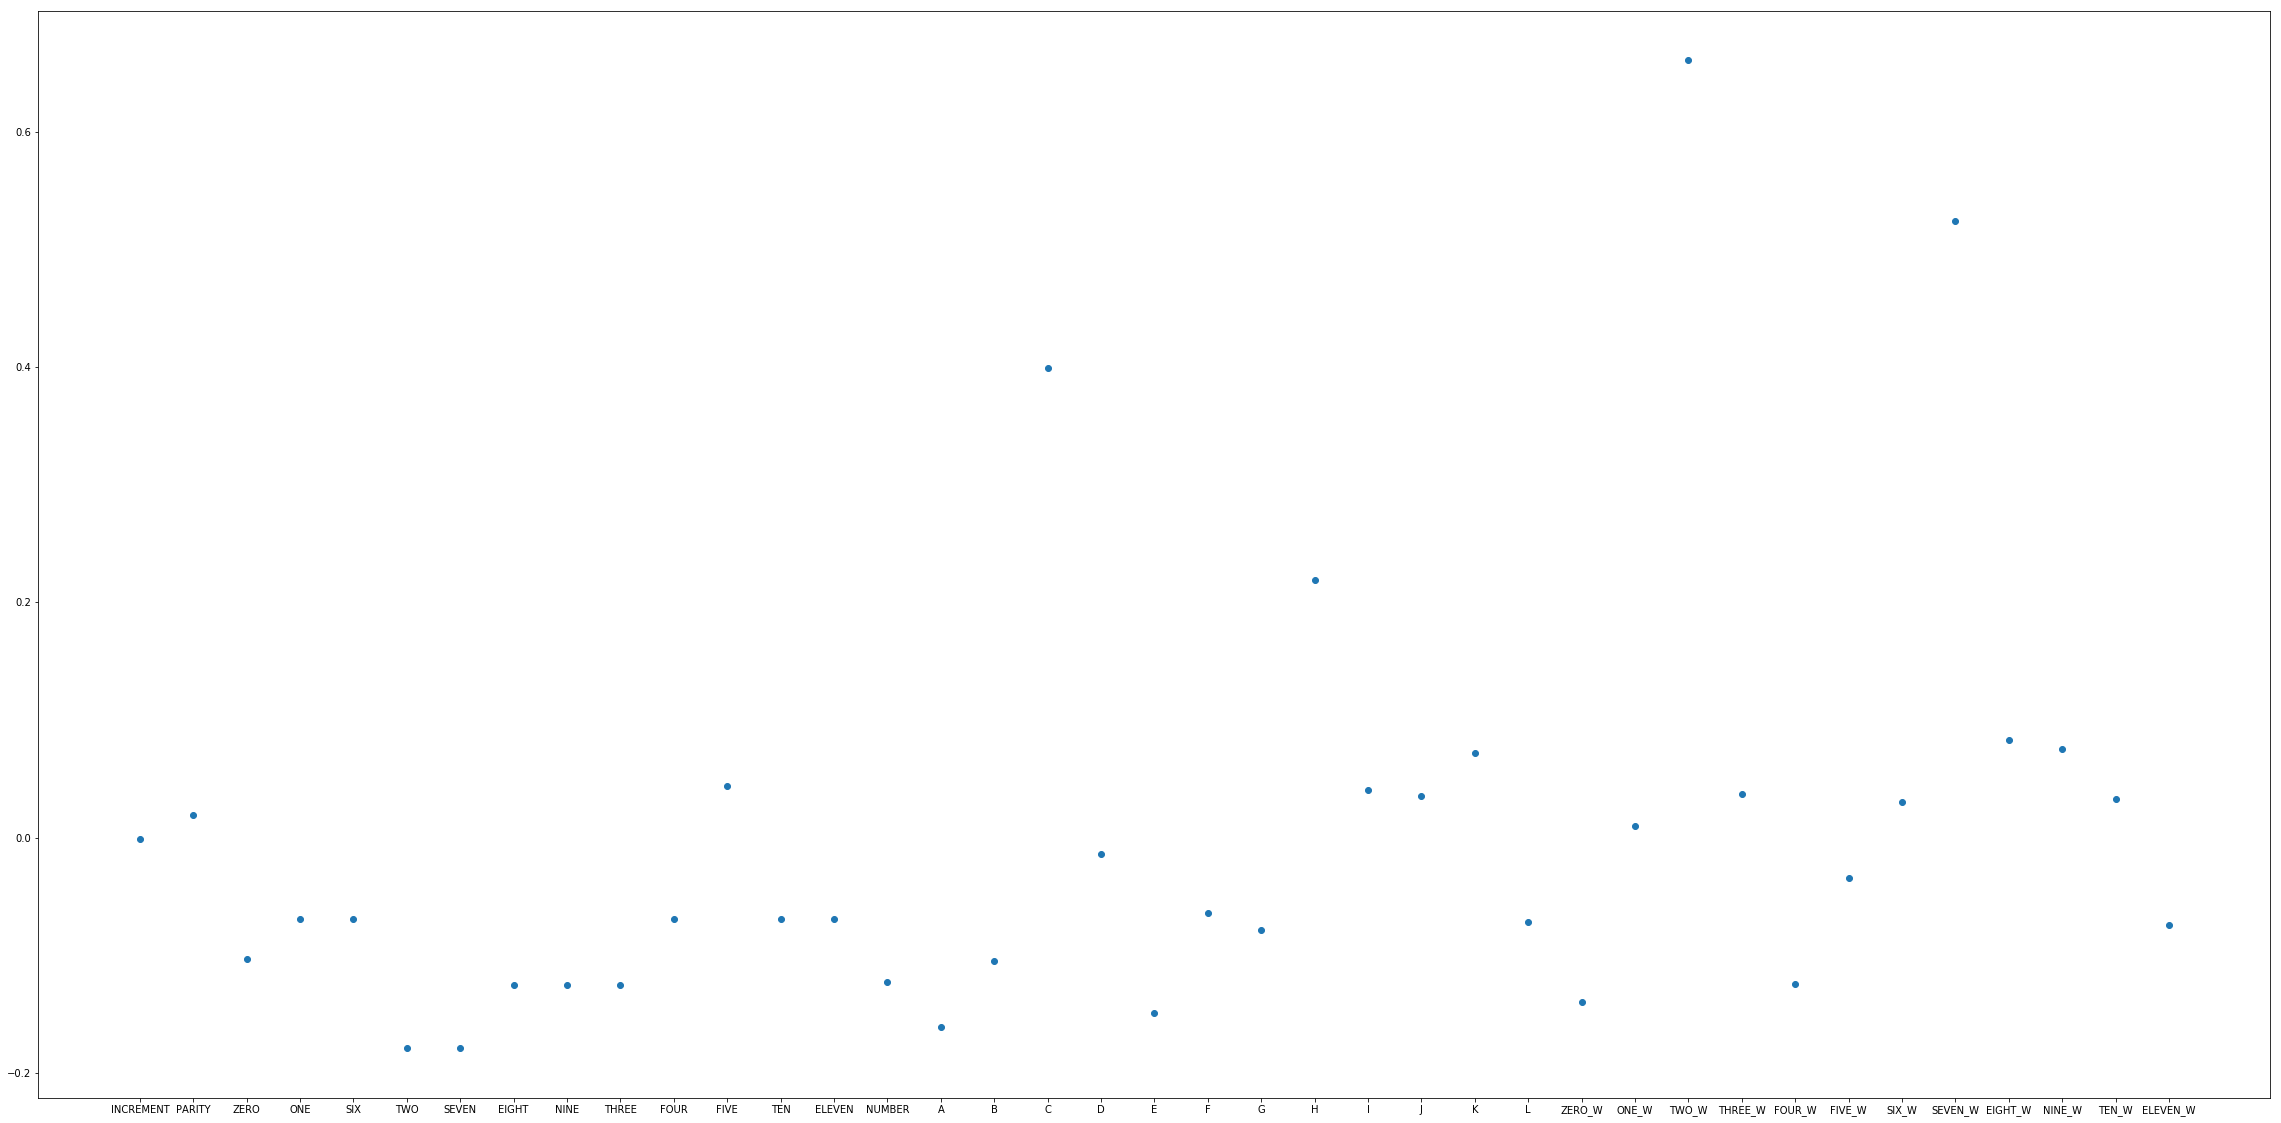

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


succ = (eight * ~T)
even_odd = ~parity*succ
test = succ.v

similarity = []
for sp_name in vocab.keys:
    vec = vocab.parse(sp_name)
    similarity.append(vec.compare(test))
 
   
#similarity = vocab.dot(test)   # compute dot product with each vector in the vocab
#similarity = similarity/np.linalg.norm(similarity[0])

plt.figure(figsize = (40,20))    
plt.plot(vocab.keys, similarity, 'o', label=vocab.keys)   
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Succ1 works, succ2 doesn't always work (works for training examples, but not for test), succ3 doesn't work. The solution is to clean up the vector after applying every succ transformation before applying the next one.

While successor relationship is beautifully captured, even-odd also seems to be beautifully captured now that I see it (because I increased the dimensions to 64*2 from 64). 

Before:
even-odd is captured in the sense that for an even vector, even is always more similar than odd, however there are other vectors like two etc. that can also be as similar as even. Maybe the solution is to only compare between even and odd since we are only looking for that decision.

In [26]:
print (np.linalg.norm(similarity[0]))

0.0013629569844803905


Same problem: for every answer, the other nodes at the same level (though with different parents) also show up as close contenders. This is worse than the other sequence encoding scheme though. 